In [630]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_1samp, norm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

In [631]:
dataset1 = pd.read_csv("dataset1.csv")
dataset2 = pd.read_csv("dataset2.csv")
dataset1.head()

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


In [632]:
dataset2.head()

,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [633]:
refined_dataset2 = dataset2.copy()
refined_dataset2["obs_start_time"] = pd.to_datetime(refined_dataset2["time"], format="%d/%m/%Y %H:%M")
refined_dataset2.drop(columns=["time"], inplace=True) # we have obs_start_time
refined_dataset2["obs_end_time"] = refined_dataset2["obs_start_time"] + pd.to_timedelta(30, unit="m")
# track observation number
refined_dataset2 = refined_dataset2.reset_index().rename(columns={"index": "obs_num"})
refined_dataset2["obs_num"] += 1

refined_dataset1 = dataset1.copy()
refined_dataset1["start_time"] = pd.to_datetime(refined_dataset1["start_time"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_start"] = pd.to_datetime(refined_dataset1["rat_period_start"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_end"] = pd.to_datetime(refined_dataset1["rat_period_end"], format="%d/%m/%Y %H:%M")

# calculated end time of bat
refined_dataset1["end_time"] = refined_dataset1["start_time"] + pd.to_timedelta(refined_dataset1["bat_landing_to_food"], unit="s")


# calculated the time between rat landing and bat goes to food
refined_dataset1["rat_landing_to_bat_food"] = refined_dataset1["seconds_after_rat_arrival"] + refined_dataset1["bat_landing_to_food"]
refined_dataset1["rat_stay"] = (refined_dataset1["rat_period_end"] - refined_dataset1["rat_period_start"]).dt.total_seconds()

Count of positive rewards 484
Count of negative rewards 423
Count of positive risks 449
Count of negative rewards 458


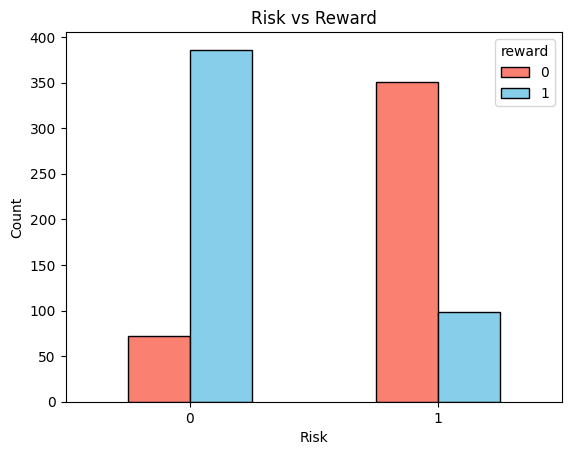

In [634]:
# To check how rewarding it is when taken risk
def risk_vs_reward_show(dataset):
    print("Count of positive rewards", dataset[dataset["reward"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["reward"] == 0].shape[0])
    print("Count of positive risks", dataset[dataset["risk"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["risk"] == 0].shape[0])

    # Count of risks vs rewards
    counts = dataset.groupby(["risk", "reward"]).size().unstack(fill_value=0)    
    counts.plot(kind="bar", color=["salmon", "skyblue"], edgecolor="black", title="Risk vs Reward")
    plt.ylabel("Count")
    plt.xlabel("Risk")
    plt.xticks(rotation=0)
    plt.show()

risk_vs_reward_show(refined_dataset1)

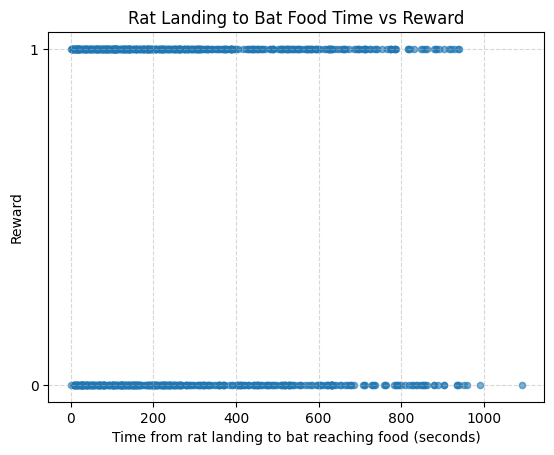

In [635]:
# To see the relationship between time taken from rat landing to bat reaching food and reward
refined_dataset1.plot.scatter(
    x="rat_landing_to_bat_food",
    y="reward",
    alpha=0.6,
    title="Rat Landing to Bat Food Time vs Reward"
)

plt.xlabel("Time from rat landing to bat reaching food (seconds)")
plt.ylabel("Reward")
plt.yticks([0,1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [636]:
refined_dataset1[["bat_landing_to_food", "rat_stay", "risk", "reward", "seconds_after_rat_arrival"]].describe()

,bat_landing_to_food,rat_stay,risk,reward,seconds_after_rat_arrival
count,907.000000,907.000000,907.000000,907.000000,907.000000
mean,11.713134,550.782800,0.495039,0.533627,282.877619
std,27.644410,375.302298,0.500251,0.499143,240.974918
min,0.010238,0.000000,0.000000,0.000000,0.000000
25%,1.000000,240.000000,0.000000,0.000000,89.500000
50%,4.000000,540.000000,0.000000,1.000000,206.000000
75%,11.500000,780.000000,1.000000,1.000000,446.500000
max,443.000000,3540.000000,1.000000,1.000000,949.000000


In [637]:
refined_dataset2[["bat_landing_number", "food_availability", "rat_arrival_number", "rat_minutes"]].describe()

,bat_landing_number,food_availability,rat_arrival_number,rat_minutes
count,2123.000000,2123.000000,2123.000000,2123.000000
mean,32.083373,2.445874,0.444654,1.994442
std,25.614431,1.218353,1.019195,6.793397
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,1.962206,0.000000,0.000000
50%,27.000000,2.951877,0.000000,0.000000
75%,48.000000,3.105873,1.000000,0.158333
max,178.000000,4.000000,17.000000,120.000000


In [638]:
# merge datasets
combined_dataset = refined_dataset2.assign(key=1).merge(
    refined_dataset1.assign(key=1), on="key"
).drop("key", axis=1)

# Keep only overlapping intervals
combined_dataset = combined_dataset[
    (combined_dataset["rat_period_start"] <= combined_dataset["obs_end_time"]) &
    (combined_dataset["rat_period_end"] >= combined_dataset["obs_start_time"])
]

combined_dataset.sort_values(by="obs_num", ascending=True)
combined_dataset.head()

,obs_num,month_x,hours_after_sunset_x,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time,start_time,...,seconds_after_rat_arrival,risk,reward,month_y,sunset_time,hours_after_sunset_y,season,end_time,rat_landing_to_bat_food,rat_stay
8178,10,0,4.0,51,2.968874,1.283333,2,2017-12-26 20:43:00,2017-12-26 21:13:00,2017-12-26 20:57:00,...,199,0,0,0,26/12/2017 16:43,4.237500,0,2017-12-26 20:57:05,204.0,300.0
8179,10,0,4.0,51,2.968874,1.283333,2,2017-12-26 20:43:00,2017-12-26 21:13:00,2017-12-26 20:57:00,...,239,0,0,0,26/12/2017 16:43,4.248611,0,2017-12-26 20:57:01,240.0,300.0
9077,11,0,4.5,53,2.561404,4.866667,1,2017-12-26 21:13:00,2017-12-26 21:43:00,2017-12-26 21:24:00,...,88,1,0,0,26/12/2017 16:43,4.684444,0,2017-12-26 21:24:15,103.0,300.0
9078,11,0,4.5,53,2.561404,4.866667,1,2017-12-26 21:13:00,2017-12-26 21:43:00,2017-12-26 21:24:00,...,113,0,1,0,26/12/2017 16:43,4.691389,0,2017-12-26 21:24:06,119.0,300.0
9079,11,0,4.5,53,2.561404,4.866667,1,2017-12-26 21:13:00,2017-12-26 21:43:00,2017-12-26 21:24:00,...,121,0,1,0,26/12/2017 16:43,4.693611,0,2017-12-26 21:24:03,124.0,300.0


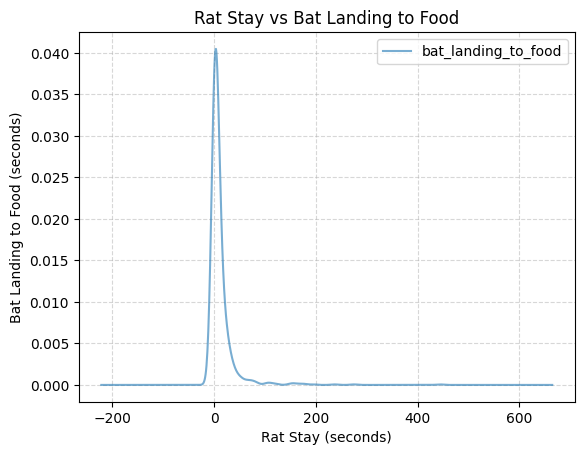

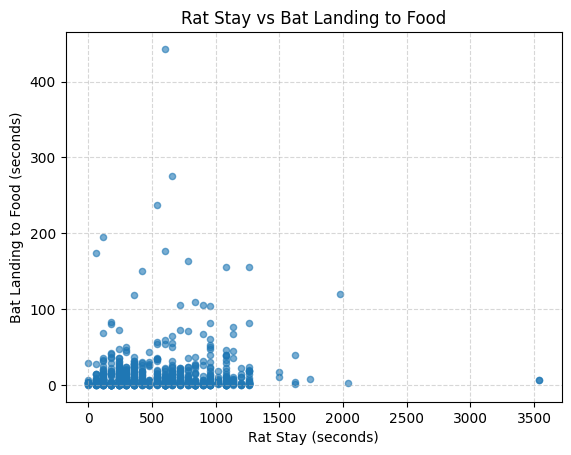

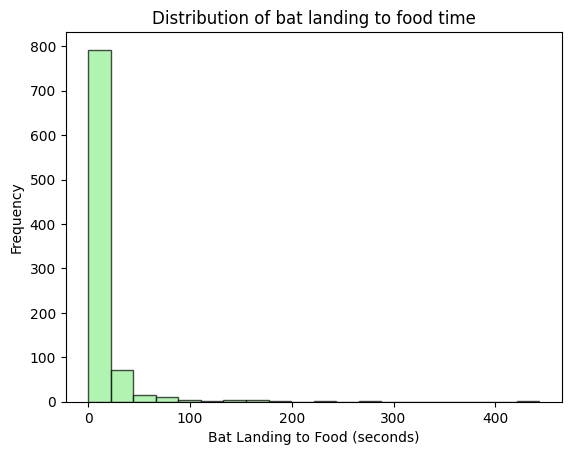

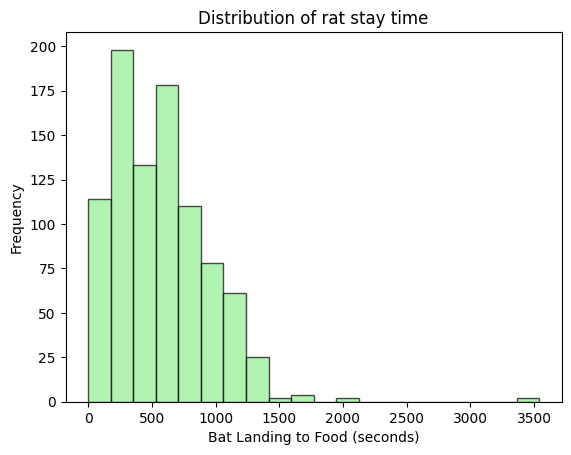

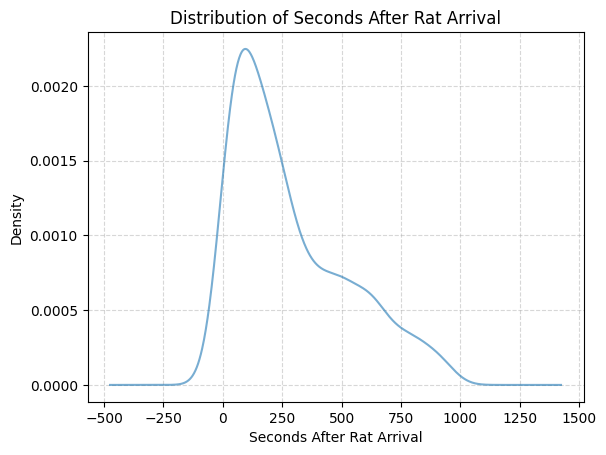

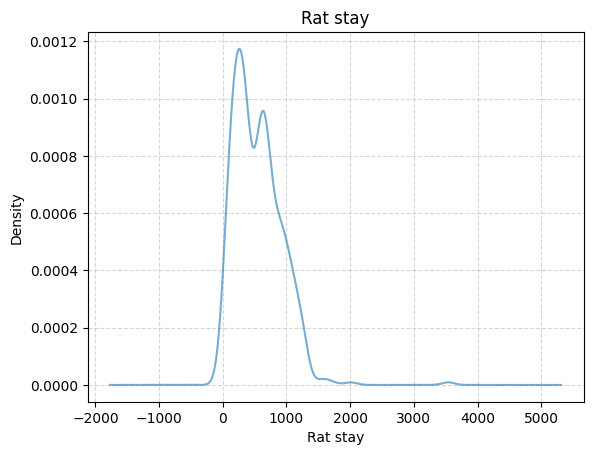

In [639]:
# Compare how the bat landing to food time with the rat stay duration
refined_dataset1.plot.kde(
    x="rat_stay",
    y="bat_landing_to_food",
    alpha=0.6,
    title="Rat Stay vs Bat Landing to Food"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Bat Landing to Food (seconds)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

refined_dataset1.plot.scatter(
    x="rat_stay",
    y="bat_landing_to_food",
    alpha=0.6,
    title="Rat Stay vs Bat Landing to Food"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Bat Landing to Food (seconds)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

refined_dataset1["bat_landing_to_food"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of bat landing to food time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

refined_dataset1["rat_stay"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of rat stay time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

refined_dataset1['seconds_after_rat_arrival'].plot.kde(
    alpha=0.6, 
    title="Distribution of Seconds After Rat Arrival"
)
plt.xlabel("Seconds After Rat Arrival")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

refined_dataset1['rat_stay'].plot.kde(
    alpha=0.6, 
    title="Rat stay"
)
plt.xlabel("Rat stay")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

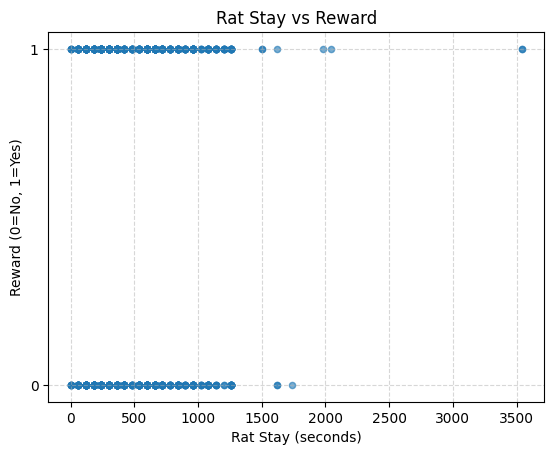

In [640]:
# 1. Scatter plot: rat_stay vs reward
refined_dataset1.plot.scatter(
    x="rat_stay",
    y="reward",
    alpha=0.6,
    title="Rat Stay vs Reward"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Reward (0=No, 1=Yes)")
plt.yticks([0, 1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

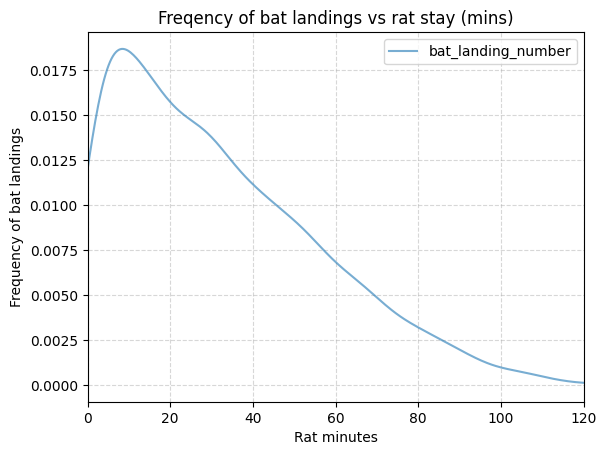

In [641]:
# To see the relationship between number of bats and rat stay time
refined_dataset2.plot.kde(
    x="rat_minutes",
    y="bat_landing_number",
    alpha=0.6,
    title="Freqency of bat landings vs rat stay (mins)"
)

# Limit to observed data range only
plt.xlim(refined_dataset2["rat_minutes"].min(),
         refined_dataset2["rat_minutes"].max())

plt.xlabel("Rat minutes")
plt.ylabel("Frequency of bat landings")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [642]:
# Create food scarcity indicator
refined_dataset2['food_scarcity'] = pd.cut(refined_dataset2['food_availability'], 
                                          bins=3, labels=['Scarce', 'Moderate', 'Abundant'])

In [643]:
refined_dataset2

,obs_num,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time,food_scarcity
0,1,0,-0.5,20,4.000000,0.0,0,2017-12-26 16:13:00,2017-12-26 16:43:00,Abundant
1,2,0,0.0,28,4.000000,0.0,0,2017-12-26 16:43:00,2017-12-26 17:13:00,Abundant
2,3,0,0.5,25,4.000000,0.0,0,2017-12-26 17:13:00,2017-12-26 17:43:00,Abundant
3,4,0,1.0,71,4.000000,0.0,0,2017-12-26 17:43:00,2017-12-26 18:13:00,Abundant
4,5,0,1.5,44,3.753857,0.0,0,2017-12-26 18:13:00,2017-12-26 18:43:00,Abundant
...,...,...,...,...,...,...,...,...,...,...
2118,2119,6,8.0,20,1.000000,0.0,0,2018-06-01 03:41:00,2018-06-01 04:11:00,Scarce
2119,2120,6,8.5,7,1.000000,0.0,0,2018-06-01 04:11:00,2018-06-01 04:41:00,Scarce
2120,2121,6,9.0,6,1.000000,0.0,0,2018-06-01 04:41:00,2018-06-01 05:11:00,Scarce
2121,2122,6,9.5,7,1.000000,0.0,0,2018-06-01 05:11:00,2018-06-01 05:41:00,Scarce


<Axes: title={'center': 'Bat activity throughout the night'}, xlabel='Hours After Sunset', ylabel='Number of Bat Landings'>

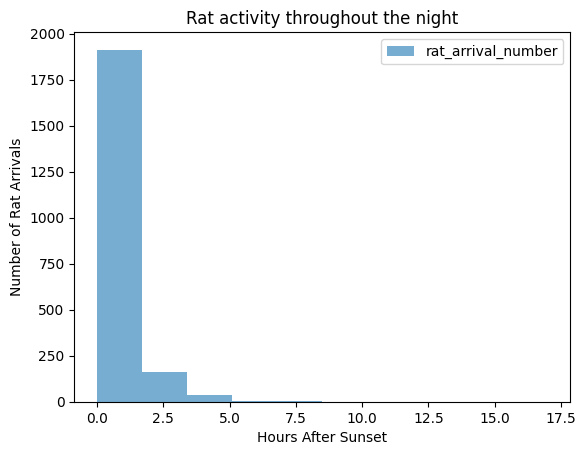

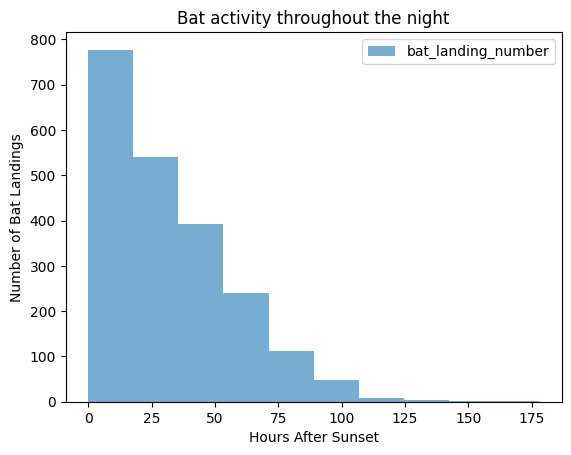

In [644]:
refined_dataset2.plot.hist(
    x='hours_after_sunset', 
    y='rat_arrival_number', 
    alpha=0.6,
    title='Rat activity throughout the night',
    xlabel='Hours After Sunset',
    ylabel='Number of Rat Arrivals'
)

refined_dataset2.plot.hist(
    x='hours_after_sunset', 
    y='bat_landing_number', 
    alpha=0.6,
    title='Bat activity throughout the night',
    xlabel='Hours After Sunset',
    ylabel='Number of Bat Landings'
)

<Axes: title={'center': 'Food available and Rat stay time'}, xlabel='Food availability', ylabel='Rat stay time'>

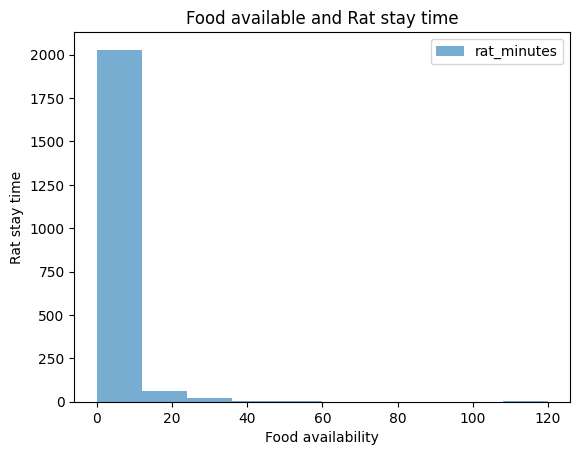

In [645]:
refined_dataset2.plot.hist(
    x='food_availability', 
    y='rat_minutes', 
    alpha=0.6,
    title='Food available and Rat stay time',
    xlabel='Food availability',
    ylabel='Rat stay time'
)

<Axes: title={'center': 'Bat landing number vs rat arrivals'}, ylabel='Density'>

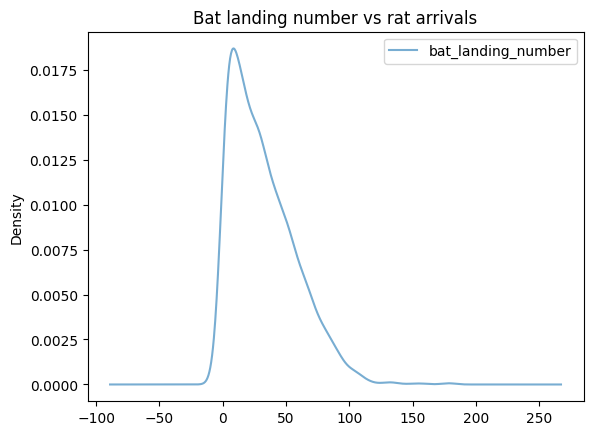

In [646]:
refined_dataset2.plot.kde(
    x='rat_arrival_number', 
    y='bat_landing_number', 
    alpha=0.6, 
    title='Bat landing number vs rat arrivals',
    xlabel='Rat arrivals',
    ylabel='Bat landing number'
)

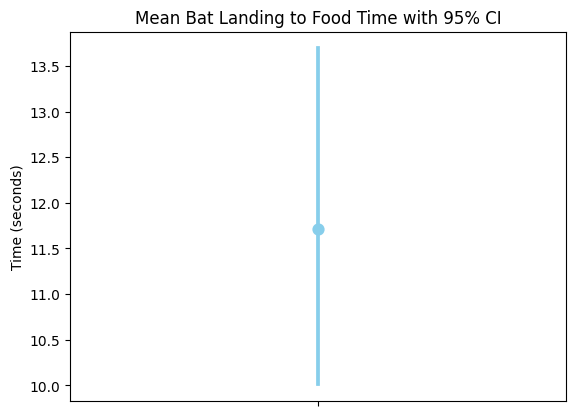

In [664]:
bat_landing_to_food_times = refined_dataset1['bat_landing_to_food'].dropna()

mean = bat_landing_to_food_times.mean()
sem = stats.sem(bat_landing_to_food_times)
ci = stats.t.interval(
    confidence=0.95, 
    df=len(bat_landing_to_food_times)-1, 
    loc=mean, 
    scale=sem
)
ci

df = pd.DataFrame({'bat_landing_to_food': bat_landing_to_food_times})
sns.pointplot(data=df, y='bat_landing_to_food', errorbar=('ci', 95), color='skyblue')
plt.title('Mean Bat Landing to Food Time with 95% CI')
plt.ylabel('Time (seconds)')
plt.show()

# With 95% confidence, the true mean bat landing-to-food time lies between ~9.9s and 13.5s. This shows that bats typically take around 10–13 seconds, but without an external baseline, we cannot say whether this indicates predator perception or just natural behavior.

In [648]:
# Inferential Analysis
# Z-TEST FOR PROPORTIONS - risk-takers vs risk-avoiders (for success)

# Get data for risk-takers and risk-avoiders
risk_takers = refined_dataset1[refined_dataset1['risk'] == 1]
risk_avoiders = refined_dataset1[refined_dataset1['risk'] == 0]

n_risk_takers = len(risk_takers)
n_risk_avoiders = len(risk_avoiders)

# Success rates (reward = 1)
success_risk_takers = risk_takers['reward'].sum()
success_risk_avoiders = risk_avoiders['reward'].sum()

p_risk_takers = success_risk_takers / n_risk_takers if n_risk_takers > 0 else 0
p_risk_avoiders = success_risk_avoiders / n_risk_avoiders if n_risk_avoiders > 0 else 0

print(f"Risk-takers: {success_risk_takers}/{n_risk_takers} = {p_risk_takers:.3f} success rate")
print(f"Risk-avoiders: {success_risk_avoiders}/{n_risk_avoiders} = {p_risk_avoiders:.3f} success rate")

# successes and sample sizes
successes = [success_risk_takers, success_risk_avoiders]
samples = [n_risk_takers, n_risk_avoiders]

# two-sided test
z_statistic, p_value_z = proportions_ztest(successes, samples, alternative="two-sided")

print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value (two-tailed): {p_value_z:.4f}")

if p_value_z < 0.05:
    if p_risk_takers > p_risk_avoiders:
        print("CONCLUSION: risk-takers have significantly HIGHER success rates!")
    else:
        print("CONCLUSION: risk-avoiders have significantly HIGHER success rates!")
else:
    print("CONCLUSION: No significant difference in success rates.")

Risk-takers: 98/449 = 0.218 success rate
Risk-avoiders: 386/458 = 0.843 success rate
Z-statistic: -18.8504
P-value (two-tailed): 0.0000
CONCLUSION: risk-avoiders have significantly HIGHER success rates!


In [649]:
# H0 (null hypothesis): No difference in bat_landing_to_food between risk-takers and risk-avoiders.
# H1 (alternative hypothesis): There is a difference between the two groups.

risk0 = refined_dataset1[refined_dataset1['risk']==0]['bat_landing_to_food'].dropna()
risk1 = refined_dataset1[refined_dataset1['risk']==1]['bat_landing_to_food'].dropna()

print("Risk=0 mean:", risk0.mean(), "std:", risk0.std(), "n:", len(risk0))
print("Risk=1 mean:", risk1.mean(), "std:", risk1.std(), "n:", len(risk1))

t_stat, p_val = stats.ttest_ind(risk0, risk1, equal_var=False)

print("\nT-test results:")
print("t = %.3f" % t_stat)
print("p = %.4f" % p_val)

if p_val < 0.05:
    print("There is a significant difference in bat landing times between risk-takers and risk-avoiders.")
    print("Risk takers have more bat landing to food time.")
else:
    print("There is no significant difference in bat landing times between the two groups.")

Risk=0 mean: 7.124468673360263 std: 20.524740089366194 n: 458
Risk=1 mean: 16.39377690842762 std: 32.74559623806908 n: 449

T-test results:
t = -5.096
p = 0.0000
There is a significant difference in bat landing times between risk-takers and risk-avoiders.
Risk takers have more bat landing to food time.


In [650]:
refined_dataset1['risk'].value_counts().sort_index()


risk
0    458
1    449
Name: count, dtype: int64

In [651]:
refined_dataset2[['rat_arrival_number', 'bat_landing_number']].corr()

,rat_arrival_number,bat_landing_number
rat_arrival_number,1.000000,-0.073536
bat_landing_number,-0.073536,1.000000


<Axes: title={'center': 'bat_landing_to_food'}, xlabel='risk'>

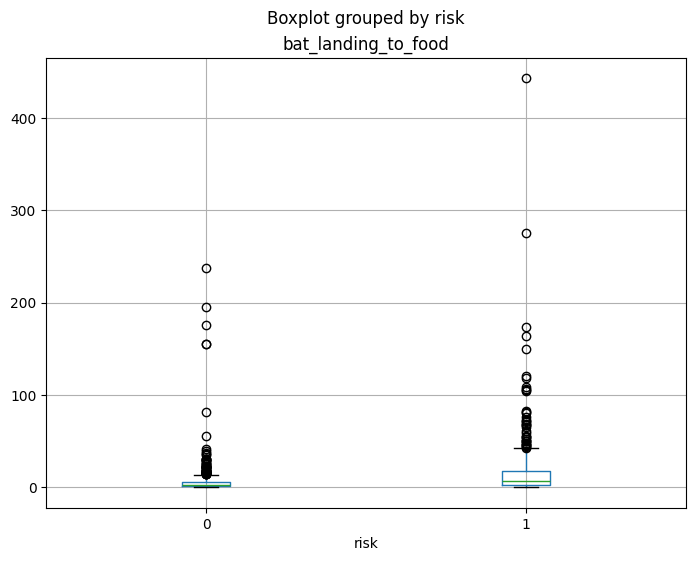

In [652]:
refined_dataset1.boxplot(column='bat_landing_to_food', by='risk', 
                           figsize=(8,6))

In [653]:
# Inferential Analysis
# Z-TEST FOR PROPORTIONS - bat landing to food time by risk bahavior

risk_avoid_bat_landing_to_food = refined_dataset1[refined_dataset1['risk'] == 0]['bat_landing_to_food']
risk_take_bat_landing_to_food = refined_dataset1[refined_dataset1['risk'] == 1]['bat_landing_to_food']

# 2. One-sided test (risk=1 mean > risk=0 mean)
t_stat_greater, p_val_greater = ttest_ind(risk_take_bat_landing_to_food, risk_avoid_bat_landing_to_food, equal_var=False, alternative='greater')
print("\nT-test (one-sided, mean1 > mean0):")
print("t-statistic =", t_stat_greater, ", p-value =", p_val_greater)
if p_val_greater < 0.05:
    print("CONCLUSION: Bats take longer time to go to food when they take risk.")
else:
    print("CONCLUSION: Bats take longer time to go to food when they don't take risk.")


T-test (one-sided, mean1 > mean0):
t-statistic = 5.0964658799597675 , p-value = 2.1918227190738191e-07
CONCLUSION: Bats take longer time to go to food when they take risk.


In [654]:
# Inferential Analysis
# T-TEST FOR PROPORTIONS - food availability vs bat landing numbers

# Split by high vs low food availability
food_median = refined_dataset2['food_availability'].median()
high_food_activity = refined_dataset2[refined_dataset2['food_availability'] > food_median]['bat_landing_number']
low_food_activity = refined_dataset2[refined_dataset2['food_availability'] <= food_median]['bat_landing_number']

t_stat, p_val = stats.ttest_ind(low_food_activity, high_food_activity, equal_var=True, alternative='greater')
print(f"High food availability - Mean bat landings: {high_food_activity.mean():.2f}")
print(f"Low food availability - Mean bat landings: {low_food_activity.mean():.2f}")

if p_val < 0.05:
    if low_food_activity.mean() > high_food_activity.mean():
        print("CONCLUSION: More bats land when food is scarce (increased vigilance/competition)")
    else:
        print("CONCLUSION: Less bats land when food is scarce")
else:
    print("CONCLUSION: No difference in bat landing number by food availability")

High food availability - Mean bat landings: 31.82
Low food availability - Mean bat landings: 32.35
CONCLUSION: No difference in bat landing number by food availability


In [655]:
refined_dataset1["habit"].unique()

array(['rat', 'fast', 'pick', 'bat_fight', 'rat_and_no_food', nan,
       'rat_and_others', 'pick_and_others', 'gaze', 'pick_rat', 'bat',
       'both', 'pick_bat',
       '94.0,305.0,239.0,416.0; 364.8,139.3,462.3,241.3', 'rat attack',
       'attack_rat', 'bat_and_rat', 'rat_attack', 'other_bats',
       'rat_pick', 'rat_and_bat', 'bowl_out', 'other_bat',
       '373.0,80.0,504.0,148.0; 274.6,110.7,382.4,267.3', 'other',
       '245.6,179.5,321.4,314.0; 522.4,0.3,592.0,95.5', 'eating',
       'rat_to_bat', 'other_bats/rat',
       '405.6,112.3,513.1,215.4; 464.1,197.7,614.9,334.3; 511.5,301.1,639.4,388.9',
       'pick_and_all', 'bat_and_pick', 'bat_fight_and_pick',
       '187.0,152.0,304.0,240.0; 567.9,88.6,621.1,140.3',
       '44.0,77.0,157.0,240.0; 253.0,96.0,346.0,147.0',
       '397.7,159.7,580.2,330.5; 252.0,92.0,346.0,149.0', 'pick_and_bat',
       '218.0,171.0,381.0,269.0; 239.0,106.0,315.0,155.0',
       '423.0,155.9,535.6,370.9; 238.0,99.0,314.0,160.0',
       'eating_and

In [ ]:
def habit_analysis(habit):
    if pd.isna(habit):
        return None
    
    habit = str(habit).lower()
    
    if 'attack' in habit or 'fight' in habit in habit:
        return 'fighting'
    elif ('rat' in habit and 'pick' not in habit and 'eat' not in habit) or ('other' in habit and 'rat' in habit):
        return 'rat_around'
    elif 'eating' in habit or 'pick' in habit:
        if 'rat' in habit and 'bat' in habit:
            return 'both_eating'
        if 'bat' in habit:
            return 'bat_eating'
        else:
            return 'rat_eating'
    elif 'fast' in habit:
        return 'moving_fast'
    elif 'gaze' in habit:
        return 'looking_around'
    else:
        return 'unclear'
    

refined_dataset1['behaviors'] = refined_dataset1['habit'].apply(habit_analysis)
refined_dataset1["behaviors"]
situations_with_rats = ['fighting', 'rat_around', 'rat_eating', 'both_eating']

times_with_rats = refined_dataset1[refined_dataset1['behaviors'].isin(situations_with_rats)]['bat_landing_to_food']
times_without_rats = refined_dataset1[~refined_dataset1['behaviors'].isin(situations_with_rats)]['bat_landing_to_food']

print(f"Out of {len(refined_dataset1)} bat visits, rats were involved in {len(times_with_rats)} cases")

# Clean out missing data
with_rats = times_with_rats.dropna()
without_rats = times_without_rats.dropna()

t_stat, p_val = stats.ttest_ind(times_with_rats, times_without_rats)

print(f"When rats were around - bats waited {times_with_rats.mean():.1f} seconds before eating")
print(f"When no rats - bats waited {times_without_rats.mean():.1f} seconds before eating")
print(f"Statistical test: t={t_stat:.2f}, p-value={p_val:.4f}")

if p_val < 0.05:
    if times_with_rats.mean() > times_without_rats.mean():
        print("RESULT: Bats were significantly more cautious when rats were present")
    else:
        print("RESULT: Bats were actually less cautious when rats were around")
else:
    print("RESULT: No clear difference in caution levels")





Out of 907 bat visits, rats were involved in 499 cases
When rats were around - bats waited 14.9 seconds before eating
When no rats - bats waited 7.8 seconds before eating
Statistical test: t=3.87, p-value=0.0001
RESULT: Bats were significantly more cautious when rats were present


In [661]:
median_rat = np.median(refined_dataset2['rat_arrival_number'])
no_rats = refined_dataset2[refined_dataset2['rat_arrival_number'] == 0]['bat_landing_number']
yes_rats = refined_dataset2[refined_dataset2['rat_arrival_number'] != 0]['bat_landing_number']

z_stat, p_value = ztest(no_rats, yes_rats, alternative='larger')
print("Median Landings:", median_rat)
print("Mean Landings (no rats):", median_rat)
print("Mean Landings (yes rats):", median_rat)
print(f"Z-stat: {z_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("CONCLUSION: Fewer bats land when rats are present (significant).")
else:
    print("CONCLUSION: No clear difference in bat landing behavior.")

Median Landings: 0.0
Mean Landings (no rats): 0.0
Mean Landings (yes rats): 0.0
Z-stat: 4.68691629185779, p-value: 1.3867616995576605e-06
CONCLUSION: Fewer bats land when rats are present (significant).
